In [5]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.convolution

import pandas as pd

In [6]:
# Finding the centre of the star in the image

def centroid(image_cutout, start_x, start_y):
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid(np.arange(start_x, start_x + x_size),
                         np.arange(start_y, start_y + y_size))
    
    x_center = np.sum(image_cutout*xx) / np.sum(image_cutout)
    y_center = np.sum(image_cutout*yy) / np.sum(image_cutout)
    
    return (x_center, y_center)

In [7]:


def gaussian2D(radius, mu):
    
    return 1 / ( mu**2*2*np.pi ) * np.exp( -0.5 * ( ( radius ) / mu )**2 )

In [8]:
# Passing over the centroids x and y
#This might not be at the centre of the images
def psf_gaussian_flux(image_cutout, centroid_x, centroid_y, radius, start_x, start_y):    
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid( np.arange(start_x, start_x + x_size ),
                          np.arange(start_y, start_y + y_size ) )
    
    r = np.sqrt( (xx - centroid_x)**2 + (yy - centroid_y)**2 )
    
    psf_image = gaussian2D( r, radius )
    psf_flux = np.sum( psf_image * cutout ) / np.sum( psf_image**2 )
    
    return psf_flux

In [9]:
#Finding the peaks of both x and y

def find_peaks(image, threshold):
    
    peak_x_values = [] 
    peak_y_values = []
    edgewidth = 5
    
    for i in range(edgewidth, image.shape[0] - edgewidth):
        for j in range(edgewidth, image.shape[1] - edgewidth):
            pixel = image[i,j]
            if(pixel < threshold):
                continue
            if(pixel > image[i + 1, j] and               
               pixel > image[i - 1, j] and
               pixel > image[i , j + 1] and
               pixel > image[i , j - 1] and
               pixel > image[i + 1, j - 1] and
               pixel > image[i - 1, j + 1] and
               pixel > image[i - 1, j - 1] and
               pixel > image[i + 1, j + 1]):
                peak_x_values.append(i)
                peak_y_values.append(j)
                
    #We then append them to new arrays       
    return np.array(peak_x_values), np.array(peak_y_values)

In [10]:
#Putting all the above functions into one that will find sources then measure their sizes and fluxes
#Outputs a table

def run_photometry(image, threshold, psf_width):

    peak_xs, peak_ys = find_peaks(convolved_image, threshold)
    
    moments_x = []
    moments_y = []
    centroids_x = []
    centroids_y = []
    fluxes = []
    
    for peak_x, peak_y in zip(peak_xs, peak_ys):
        
        image_cutout = image[(peak_x - 5):(peak_x + 5), (peak_y - 5):(peak_y + 5)]
        start_x = int(peak_x - 5)
        start_y = int(peak_y - 5)

        centroid_x, centroid_y = centroid(image_cutout, peak_x, peak_y)
        centroids_x.append(centroid_x)
        centroids_y.append(centroid_y)

        moment_x, moment_y = second_moment_estimate(image_cutout, peak_x, peak_y, start_x, start_y)
        moments_x.append(moment_x)
        moments_y.append(moment_y)

        psf_flux = psf_gaussian_flux(image_cutout, centroid_x, centroid_y, psf_width, start_x, start_y)
        fluxes.append(psf_flux)
        
    return pd.DataFrame({"centroid_x": centroids_x,
                         "centroid_y": centroids_y,
                         "moment_x": moments_x,
                         "moment_y": moments_y,
                         "gaussian_flux": fluxes})
    

In [11]:
#This method was outlined in the LLST Data science fellowship program lectures
#They use a method called 'second moment' in order to estimate the size of the image 

# Once we have sources identified, we want to identify which is good for PSF determination, then measure the PSF
# We're going to do both of these at once, we're going to measure sizes for all sources, and then use the mean size as our PSF model. Outlined in LLST.


def second_moment_estimate(image_cutout, centroid_x, centroid_y, start_x, start_y):
    
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid(np.arange(start_x, start_x + x_size),
                         np.arange(start_y, start_y + y_size))
    
    x_width = np.sqrt(np.sum( (image_cutout * ( xx - centroid_x) )**2) ) / np.sqrt( np.sum( image_cutout**2 ) )
    y_width = np.sqrt(np.sum( (image_cutout * ( yy - centroid_y) )**2) ) / np.sqrt( np.sum( image_cutout**2 ) )
    
    return (x_width, y_width)

Wall time: 1min 10s


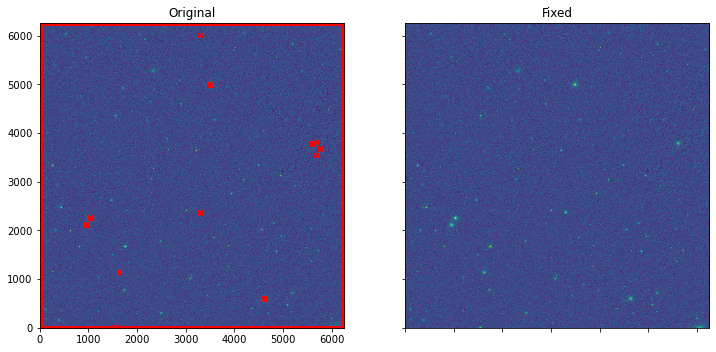

In [12]:
%%time
#All im doing here is really importing the FITS file, identifying all of the saturated pixels and then removing them with astropy.

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

filename = get_pkg_data_filename('panSTARRS T CrB g.fits')

hdu = fits.open(filename)
img = hdu[1].data



kernel = Gaussian2DKernel(x_stddev=3)


fixed_image = interpolate_replace_nans(img, kernel)


plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) 

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(img, origin='lower', interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))

ax1.plot(x, y, 'rx', markersize=4)
ax1.set_title("Original")


ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(fixed_image, origin='lower', interpolation='nearest', cmap='viridis')
ax2.set_title("Fixed")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
plt.savefig('Original Aperture and Interpolated images')

image = fixed_image

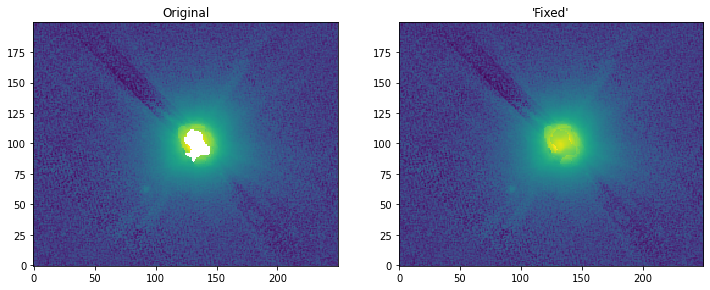

In [13]:
#All thats done here is now comparing the original cutout to the crude interpolation
f = fits.open("panSTARRS T CrB g.fits")
image_sat = f[1].data


cutout_sat = image_sat[4900:5100, 3350:3600]

cutout = image[4900:5100, 3350:3600]

plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) 

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(cutout_sat, origin='lower', interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))

#ax1.plot(x, y, 'rx', markersize=4)
ax1.set_title("Original")


ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(cutout, origin='lower', interpolation='nearest', cmap='viridis')
ax2.set_title("'Fixed'")

plt.savefig('Original Aperture and Interpolated image cutouts')

In [14]:
#Returning coordinate matrices from coordinate vectors.

xx, yy = np.meshgrid(range(2, 10), range(250, 200))
print("xx: ", xx)
print("yy: ", yy)

xx:  []
yy:  []


In [15]:
xx, yy = np.meshgrid(np.arange(0, 250), np.arange(0, 200))


In [16]:
#Taking average to find the center

x_center = np.sum(cutout*xx) / np.sum(cutout)
y_center = np.sum(cutout*yy) / np.sum(cutout)

print(x_center, y_center)

136.22099936421492 98.11635833063137


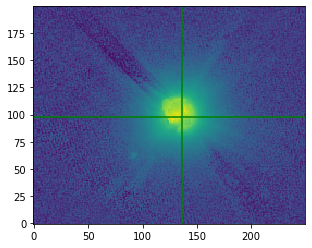

In [17]:
#Plotting the image to confirm that the centroid is correct
plt.imshow(cutout, origin='lower', interpolation='nearest', cmap='viridis')
plt.axvline(x_center, color='g')
plt.axhline(y_center, color='g')

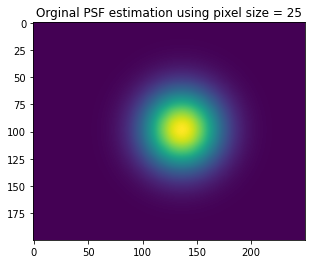

In [18]:
#Estimating the PSF
radius = np.sqrt( (xx - x_center)**2 + (yy - y_center)**2 )

psf_size_pixels = 25
psf_image = gaussian2D(radius, psf_size_pixels)
plt.imshow(psf_image)
plt.title('Orginal PSF estimation using pixel size = 25')
plt.savefig('Original estimation')

In [19]:
#Confirming the image is being simulated correctly

np.sum(psf_image)

0.9999321338080012

In [20]:
psf_flux = np.sum(psf_image * cutout) / np.sum(psf_image**2)
print(psf_flux)

31629.47006767068


In [21]:
aperture_flux = np.sum(cutout)
print(aperture_flux)


44352.156


In [22]:
##This is quite a ways off the original aperture flux, this is because of an incorrect PSF model##

In [23]:
%%time
#Using the source detection and convolved the image to find the peaks of each star, i.e this is source detection
convolved_image = astropy.convolution.convolve(image, astropy.convolution.Gaussian2DKernel(2.5))
peak_x_values, peak_y_values = find_peaks(convolved_image, 5)

Wall time: 1min 15s


In [24]:
print(peak_x_values)


[   6    8    9   42  158  165  192  202  254  309  312  334  355  363
  388  398  399  415  477  595  612  646  662  716  756  783  851  898
  952 1018 1029 1068 1109 1147 1160 1189 1265 1351 1370 1435 1473 1482
 1505 1579 1589 1650 1675 1675 1692 1749 1769 1785 1853 1887 2000 2021
 2040 2118 2124 2153 2155 2212 2233 2256 2332 2375 2399 2411 2415 2477
 2479 2627 2630 2686 2767 2810 2842 2926 2956 2996 3048 3062 3128 3193
 3208 3229 3275 3341 3346 3548 3625 3646 3658 3664 3693 3799 3896 3912
 3922 4001 4018 4060 4073 4186 4245 4247 4256 4276 4276 4357 4459 4491
 4499 4604 4639 4646 4767 4775 4802 4930 4953 4999 5014 5093 5201 5239
 5275 5281 5335 5416 5456 5554 5562 5602 5625 5707 5717 5720 5760 5835
 5953 6000 6040 6044 6060 6116 6180 6248]


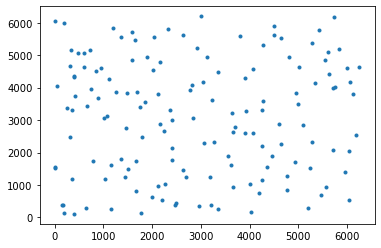

In [25]:
#plot of the stars in the image
plt.plot(peak_x_values, peak_y_values, '.')

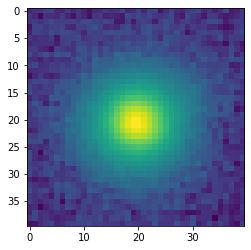

In [26]:
#Change n, prints a different star, we run through this to confirm the sources we are detecting are stars
n = 101
peak_x = peak_x_values[n]
peak_y = peak_y_values[n]
cutout = image[(peak_x - 20):(peak_x + 20), (peak_y - 20):(peak_y + 20)]

plt.imshow(cutout)

In [27]:
%%time
#Here we are just running all of the above functions and outputting our data on a table
photometry_table = run_photometry(image, 5, 2.5)

print(photometry_table[:148])

ValueError: operands could not be broadcast together with shapes (10,10) (40,40) 

In [24]:
moments_x = []
moments_y = []

#print(peak_x_values)
#print(peak_y_values)

In [25]:
#Now we just run the second estimate across all the sources. This is so we can find a particular size that fits lots of objects. This would be our PSF size. 
for peak_x , peak_y in zip(peak_x_values,peak_y_values):
    
    image_cutout = image[(peak_x - 5):(peak_x + 5), (peak_y - 5):(peak_y + 5)]
    
    start_x = int(peak_x - 5)
    
    start_y = int(peak_y - 5)
    
    
    moment_x , moment_y = second_moment_estimate(image_cutout, peak_x, peak_y, start_x, start_y)
    
    moments_x.append(moment_x)
    moments_y.append(moment_y)


In [28]:
#combining the x and y moments into a single value as the sum of squares. 
moments_sq = np.sqrt(np.array( moments_x )**2 + np.array( moments_y )**2)


plt.hist(moments_sq, bins=40)
plt.title('PSF values across the image field')
plt.ylabel('Frequency (#)')
plt.xlabel("PSF Width")
plt.savefig('PSF distribution of panSTARRS T CrB')

NameError: name 'moments_x' is not defined

In [27]:
def avg_psf(array): 
    return sum(array) / len(array) 


psf = avg_psf(moments_sq)

print('The average PSF pixel width is:', avg_psf(moments_sq))

The average PSF pixel width is: 3.7269090740535753


In [1]:
cutout = image[4900:5100, 3350:3600]
radius = np.sqrt((xx - x_center)**2 + (yy - y_center)**2)

psf_size_pixels = psf*6.8
psf_image_improved = gaussian2D(radius, psf_size_pixels)
plt.imshow(psf_image_improved)
plt.title('Improved PSF estimation using unsaturated source PSF')
plt.savefig('Improved PSF estimation using unsaturated source PSF')

corrected_psf_flux = np.sum(psf_image_improved * cutout)/np.sum(psf_image_improved**2)
print(corrected_psf_flux)

aperture_flux = np.sum(cutout)
print(aperture_flux)


print('There is now a much more improved accuracy of the PSF estimation:', ((-aperture_flux + corrected_psf_flux)/aperture_flux)*100,'% difference')

np.sum(psf_image_improved)
print(psf_image_improved[100][125])

NameError: name 'image' is not defined

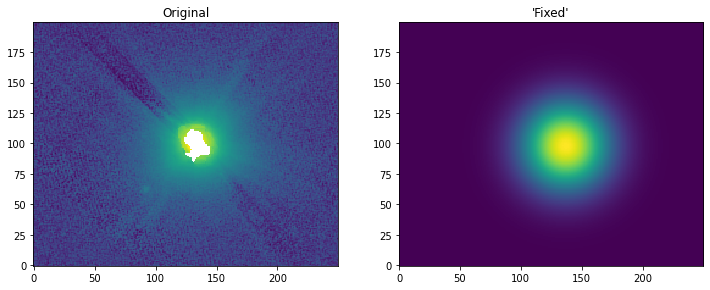

In [36]:
f = fits.open("panSTARRS T CrB g.fits")
image_sat = f[1].data


cutout_sat = image_sat[4900:5100, 3350:3600]

cutout = image[4900:5100, 3350:3600]

plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) 

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(cutout_sat, origin='lower', interpolation='nearest', cmap='viridis')
y, x = np.where(np.isnan(img))

#ax1.plot(x, y, 'rx', markersize=4)
ax1.set_title("Original")


ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(psf_image_improved, origin='lower', interpolation='nearest', cmap='viridis')
ax2.set_title("'Fixed'")

plt.savefig('Original Aperture and Interpolated image cutouts')